In [71]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.dataset import concat_examples
from chainer.cuda import to_cpu
from chainer import serializers
import matplotlib.pyplot as plt

In [72]:
class MLP(Chain):
    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)    # n_units -> n_out

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l3(h2)
        return y

In [73]:
model = MLP(n_units=10, n_out=10)  # the input size, 784, is inferred
optimizer = optimizers.SGD()
optimizer.setup(model)

In [74]:
max_epoch = 20
batchsize = 32

train, test = datasets.get_mnist()
train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize, repeat=False, shuffle=False)
mean_acc = [] 
mean_test_loss = [] 
mean_train_loss = []
train_losses = []

In [75]:
while train_iter.epoch < max_epoch:

    # ---------- One iteration of the training loop ----------
    train_batch = train_iter.next()
    image_train, target_train = concat_examples(train_batch)

    # Calculate the prediction of the network
    prediction_train = model(image_train)

    
    # Calculate the loss with softmax_cross_entropy
    loss = F.softmax_cross_entropy(prediction_train, target_train)
    train_losses.append(loss.data)

    # Calculate the gradients in the network
    model.cleargrads()
    loss.backward()

    # Update all the trainable paremters
    optimizer.update()
    # --------------------- until here ---------------------

    # Check the validation accuracy of prediction after every epoch
    if train_iter.is_new_epoch:  # If this iteration is the final iteration of the current epoch

        # Display the training loss
        #print('epoch:{:02d} train_loss:{:.04f} '.format(
        #    train_iter.epoch, float(loss.data)), end='')

        test_losses = []
        test_accuracies = []
        #train_losses = []
        while True:
            test_batch = test_iter.next()
            image_test, target_test = concat_examples(test_batch)

            # Forward the test data
            prediction_test = model(image_test)

            # Calculate the loss
            loss_test = F.softmax_cross_entropy(prediction_test, target_test)
            test_losses.append(to_cpu(loss_test.data))

            # Calculate the accuracy
            accuracy = F.accuracy(prediction_test, target_test)
            accuracy.to_cpu()
            test_accuracies.append(accuracy.data)

            if test_iter.is_new_epoch:
                test_iter.epoch = 0
                test_iter.current_position = 0
                test_iter.is_new_epoch = False
                test_iter._pushed_position = None
                break

        print('val_loss:{:.04f} val_accuracy:{:.04f}'.format(
            np.mean(test_losses), np.mean(test_accuracies)))
        mean_acc.append(np.mean(test_accuracies))
        mean_test_loss.append(np.mean(test_losses))
        mean_train_loss.append(np.mean(train_losses))
        train_losses = []

val_loss:0.4499 val_accuracy:0.8668
val_loss:0.3673 val_accuracy:0.8914
val_loss:0.3481 val_accuracy:0.9004
val_loss:0.3202 val_accuracy:0.9063
val_loss:0.3139 val_accuracy:0.9090
val_loss:0.2977 val_accuracy:0.9140
val_loss:0.2881 val_accuracy:0.9151
val_loss:0.2776 val_accuracy:0.9197
val_loss:0.2720 val_accuracy:0.9203
val_loss:0.2690 val_accuracy:0.9229
val_loss:0.2686 val_accuracy:0.9200
val_loss:0.2553 val_accuracy:0.9262
val_loss:0.2517 val_accuracy:0.9294
val_loss:0.2471 val_accuracy:0.9308
val_loss:0.2410 val_accuracy:0.9322
val_loss:0.2425 val_accuracy:0.9297
val_loss:0.2569 val_accuracy:0.9278
val_loss:0.2413 val_accuracy:0.9297
val_loss:0.2477 val_accuracy:0.9305
val_loss:0.2327 val_accuracy:0.9333


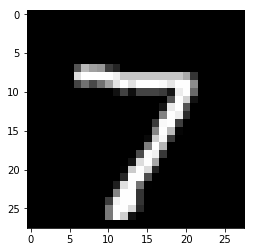

('label:', 7)
('predicted label:', 7)


In [76]:
x, t = test[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)
x = x[None, ...]

# forward calculation of the model by sending X
y = model(x)

# The result is given as Variable, then we can take a look at the contents by the attribute, .data.
y = y.data

# Look up the most probable digit number using argmax
pred_label = y.argmax(axis=1)

print('predicted label:', pred_label[0])

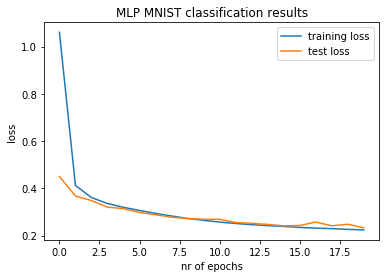

In [80]:
plt.xlabel('nr of epochs')
plt.ylabel('loss')
epochs = range(0,np.size(mean_acc))
#print np.shape(mean_acc)
plt.plot(epochs,mean_train_loss,
         label='training loss')
plt.plot(epochs,mean_test_loss,
         label='test loss')
plt.legend(loc='upper right')
plt.title('MLP MNIST classification results')
plt.show()